In [2]:
!ls


sample_data


In [3]:
!python3 utils.py

2024-12-17 19:28:24.873640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 19:28:24.911117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 19:28:24.922907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 19:28:24.948892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 19:28:26.622441: W tensorflow/compiler/tf2

In [7]:
!python3 train_cifar100.ipynb.py

2024-12-17 21:23:27.379223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 21:23:27.398550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 21:23:27.404355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 21:23:28.604864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-17 21:23:31.422936: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.10

In [12]:
!python3 predict_cifar100.ipynb.py

2024-12-17 22:07:52.824875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 22:07:52.845115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 22:07:52.851157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 22:07:54.068825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-17 22:07:56.864257: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.10

In [34]:
# Cell 1: 导入必要的库
import tensorflow as tf
import numpy as np
import os
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

# 确保notebook中显示图像
%matplotlib inline

# 导入模型创建函数
from model import swin_tiny_patch4_window7_224 as create_model


In [35]:
# Cell 2: 配置训练参数及数据集
pre_weights_path = './save_weights/model.weights.h5'  # 可选预训练权重路径
if not os.path.exists("./save_weights"):
    os.makedirs("./save_weights")

# 加载CIFAR-100数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
y_train = y_train.squeeze()  # shape变为 (50000,)
y_test = y_test.squeeze()    # shape变为 (10000,)

num_classes = 100
img_size = 224
batch_size = 128
epochs = 20
initial_lr = 0.0004
weight_decay = 1e-5
freeze_layers = False


In [36]:
# Cell 3: 定义数据预处理函数
def preprocess_train(image, label):
    # image: [H,W,3], uint8
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    # 标准化 (image/255 - mean)/std
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image/255.0 - mean) / std
    return image, label

def preprocess_val(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32)
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image/255.0 - mean) / std
    return image, label


In [37]:
# Cell 4: 创建数据集管道
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=50000).map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [38]:
# Cell 5: 创建模型及加载预训练权重
model = create_model(num_classes=num_classes)
model.build((1, img_size, img_size, 3))

# 如果有预训练权重则加载
if os.path.exists(pre_weights_path):
    model.load_weights(pre_weights_path)
    print("Loaded pre-trained weights.")
else:
    print("No pre-trained weights found, training from scratch.")

if freeze_layers:
    for layer in model.layers:
        if "head" not in layer.name:
            layer.trainable = False
        else:
            print("training {}".format(layer.name))

model.summary()


Loaded pre-trained weights.


Model: "swin_tiny_patch4_window7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_embed_5 (PatchEmbed)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer0 (BasicLayer)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer1 (BasicLayer)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (BasicLayer)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (BasicLayer)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm (LayerNormalization)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head (Dense)                         │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Cell 6: 定义损失函数、优化器及度量指标
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='train_top5_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
val_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='val_top5_accuracy')

log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
val_writer = tf.summary.create_file_writer(os.path.join(log_dir, "val"))


In [40]:
# Cell 7: 定义训练与验证步骤
@tf.function
def train_step(train_images, train_labels):
    with tf.GradientTape() as tape:
        output = model(train_images, training=True)
        ce_loss = loss_object(train_labels, output)
        # l2 loss
        import re
        matcher = re.compile(".*(bias|gamma|beta).*")
        l2loss = weight_decay * tf.add_n([
            tf.nn.l2_loss(v)
            for v in model.trainable_variables
            if not matcher.match(v.name)
        ])
        loss = ce_loss + l2loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(ce_loss)
    train_accuracy(train_labels, output)
    train_top5(train_labels, output)

@tf.function
def val_step(val_images, val_labels):
    output = model(val_images, training=False)
    loss = loss_object(val_labels, output)
    val_loss(loss)
    val_accuracy(val_labels, output)
    val_top5(val_labels, output)


In [41]:
# Cell 8: 训练主循环
best_val_acc = 0.0

# 用于绘制曲线的数据列表
hist_train_loss = []
hist_train_acc = []
hist_train_top5 = []
hist_val_loss = []
hist_val_acc = []
hist_val_top5 = []

for epoch in range(epochs):
    train_loss.reset_state()
    train_accuracy.reset_state()
    train_top5.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()
    val_top5.reset_state()

    # train
    train_bar = tqdm(train_ds)
    for images, labels in train_bar:
        train_step(images, labels)
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}, acc:{:.3f}, top5:{:.3f}".format(
            epoch+1,
            epochs,
            train_loss.result(),
            train_accuracy.result(),
            train_top5.result()
        )

    # validate
    val_bar = tqdm(val_ds)
    for images, labels in val_bar:
        val_step(images, labels)
        val_bar.desc = "valid epoch[{}/{}] loss:{:.3f}, acc:{:.3f}, top5:{:.3f}".format(
            epoch+1,
            epochs,
            val_loss.result(),
            val_accuracy.result(),
            val_top5.result()
        )

    # 写入tensorboard
    with train_writer.as_default():
        tf.summary.scalar("loss", train_loss.result(), epoch)
        tf.summary.scalar("accuracy", train_accuracy.result(), epoch)
        tf.summary.scalar("top5_accuracy", train_top5.result(), epoch)

    with val_writer.as_default():
        tf.summary.scalar("loss", val_loss.result(), epoch)
        tf.summary.scalar("accuracy", val_accuracy.result(), epoch)
        tf.summary.scalar("top5_accuracy", val_top5.result(), epoch)

    # 打印最终信息 (按照指定格式)
    print("epoch[{}/{}]: loss: {:.4f} - accuracy: {:.4f} - top-5-accuracy: {:.4f} - val_loss: {:.4f} - val_accuracy: {:.4f} - val_top-5-accuracy: {:.4f}".format(
        epoch+1,
        epochs,
        train_loss.result(),
        train_accuracy.result(),
        train_top5.result(),
        val_loss.result(),
        val_accuracy.result(),
        val_top5.result()
    ))

    # 保存训练和验证指标数据
    hist_train_loss.append(train_loss.result().numpy())
    hist_train_acc.append(train_accuracy.result().numpy())
    hist_train_top5.append(train_top5.result().numpy())
    hist_val_loss.append(val_loss.result().numpy())
    hist_val_acc.append(val_accuracy.result().numpy())
    hist_val_top5.append(val_top5.result().numpy())

    # 保存最优权重
    if val_accuracy.result() > best_val_acc:
        best_val_acc = val_accuracy.result()
        save_name = './save_weights/model.weights.h5'
        model.save_weights(save_name)
        print("Saved best model weights at epoch {}".format(epoch+1))


train epoch[1/20] loss:4.231, acc:0.056, top5:0.199: 100%|██████████| 391/391 [03:49<00:00,  1.71it/s]
valid epoch[1/20] loss:4.038, acc:0.074, top5:0.247: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


epoch[1/20]: loss: 4.2315 - accuracy: 0.0560 - top-5-accuracy: 0.1990 - val_loss: 4.0384 - val_accuracy: 0.0738 - val_top-5-accuracy: 0.2472
Saved best model weights at epoch 1


train epoch[2/20] loss:3.903, acc:0.100, top5:0.299: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[2/20] loss:3.752, acc:0.125, top5:0.350: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


epoch[2/20]: loss: 3.9031 - accuracy: 0.0997 - top-5-accuracy: 0.2987 - val_loss: 3.7521 - val_accuracy: 0.1250 - val_top-5-accuracy: 0.3502
Saved best model weights at epoch 2


train epoch[3/20] loss:3.644, acc:0.139, top5:0.379: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[3/20] loss:3.497, acc:0.166, top5:0.424: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


epoch[3/20]: loss: 3.6443 - accuracy: 0.1388 - top-5-accuracy: 0.3792 - val_loss: 3.4965 - val_accuracy: 0.1662 - val_top-5-accuracy: 0.4240
Saved best model weights at epoch 3


train epoch[4/20] loss:3.463, acc:0.172, top5:0.430: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
valid epoch[4/20] loss:3.361, acc:0.190, top5:0.463: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


epoch[4/20]: loss: 3.4632 - accuracy: 0.1723 - top-5-accuracy: 0.4301 - val_loss: 3.3613 - val_accuracy: 0.1900 - val_top-5-accuracy: 0.4631
Saved best model weights at epoch 4


train epoch[5/20] loss:3.293, acc:0.199, top5:0.476: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[5/20] loss:3.196, acc:0.219, top5:0.503: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


epoch[5/20]: loss: 3.2933 - accuracy: 0.1991 - top-5-accuracy: 0.4760 - val_loss: 3.1957 - val_accuracy: 0.2185 - val_top-5-accuracy: 0.5033
Saved best model weights at epoch 5


train epoch[6/20] loss:3.121, acc:0.229, top5:0.520: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[6/20] loss:3.011, acc:0.256, top5:0.550: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


epoch[6/20]: loss: 3.1211 - accuracy: 0.2291 - top-5-accuracy: 0.5201 - val_loss: 3.0109 - val_accuracy: 0.2559 - val_top-5-accuracy: 0.5497
Saved best model weights at epoch 6


train epoch[7/20] loss:2.999, acc:0.254, top5:0.553: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[7/20] loss:2.954, acc:0.269, top5:0.561: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]


epoch[7/20]: loss: 2.9987 - accuracy: 0.2539 - top-5-accuracy: 0.5531 - val_loss: 2.9541 - val_accuracy: 0.2695 - val_top-5-accuracy: 0.5613
Saved best model weights at epoch 7


train epoch[8/20] loss:2.885, acc:0.275, top5:0.581: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]
valid epoch[8/20] loss:2.882, acc:0.280, top5:0.585: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


epoch[8/20]: loss: 2.8848 - accuracy: 0.2745 - top-5-accuracy: 0.5812 - val_loss: 2.8820 - val_accuracy: 0.2801 - val_top-5-accuracy: 0.5854
Saved best model weights at epoch 8


train epoch[9/20] loss:2.843, acc:0.282, top5:0.589: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[9/20] loss:2.858, acc:0.279, top5:0.584: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


epoch[9/20]: loss: 2.8429 - accuracy: 0.2822 - top-5-accuracy: 0.5892 - val_loss: 2.8577 - val_accuracy: 0.2788 - val_top-5-accuracy: 0.5840


train epoch[10/20] loss:2.842, acc:0.285, top5:0.589: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]
valid epoch[10/20] loss:2.802, acc:0.296, top5:0.600: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


epoch[10/20]: loss: 2.8418 - accuracy: 0.2852 - top-5-accuracy: 0.5886 - val_loss: 2.8017 - val_accuracy: 0.2956 - val_top-5-accuracy: 0.6005
Saved best model weights at epoch 10


train epoch[11/20] loss:2.735, acc:0.305, top5:0.619: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[11/20] loss:2.685, acc:0.321, top5:0.625: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s]


epoch[11/20]: loss: 2.7354 - accuracy: 0.3054 - top-5-accuracy: 0.6191 - val_loss: 2.6851 - val_accuracy: 0.3213 - val_top-5-accuracy: 0.6248
Saved best model weights at epoch 11


train epoch[12/20] loss:2.601, acc:0.332, top5:0.648: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[12/20] loss:2.657, acc:0.325, top5:0.634: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


epoch[12/20]: loss: 2.6013 - accuracy: 0.3320 - top-5-accuracy: 0.6479 - val_loss: 2.6571 - val_accuracy: 0.3251 - val_top-5-accuracy: 0.6344
Saved best model weights at epoch 12


train epoch[13/20] loss:2.535, acc:0.349, top5:0.661: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
valid epoch[13/20] loss:2.578, acc:0.337, top5:0.645: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


epoch[13/20]: loss: 2.5347 - accuracy: 0.3491 - top-5-accuracy: 0.6613 - val_loss: 2.5784 - val_accuracy: 0.3373 - val_top-5-accuracy: 0.6448
Saved best model weights at epoch 13


train epoch[14/20] loss:2.467, acc:0.358, top5:0.678: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
valid epoch[14/20] loss:2.592, acc:0.343, top5:0.647: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s]


epoch[14/20]: loss: 2.4668 - accuracy: 0.3581 - top-5-accuracy: 0.6778 - val_loss: 2.5921 - val_accuracy: 0.3428 - val_top-5-accuracy: 0.6474
Saved best model weights at epoch 14


train epoch[15/20] loss:2.465, acc:0.363, top5:0.677: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
valid epoch[15/20] loss:2.561, acc:0.351, top5:0.657: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


epoch[15/20]: loss: 2.4650 - accuracy: 0.3627 - top-5-accuracy: 0.6772 - val_loss: 2.5609 - val_accuracy: 0.3511 - val_top-5-accuracy: 0.6573
Saved best model weights at epoch 15


train epoch[16/20] loss:2.422, acc:0.367, top5:0.686: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]
valid epoch[16/20] loss:2.456, acc:0.364, top5:0.680: 100%|██████████| 79/79 [00:11<00:00,  6.80it/s]


epoch[16/20]: loss: 2.4222 - accuracy: 0.3673 - top-5-accuracy: 0.6864 - val_loss: 2.4559 - val_accuracy: 0.3643 - val_top-5-accuracy: 0.6801
Saved best model weights at epoch 16


train epoch[17/20] loss:2.288, acc:0.398, top5:0.715: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[17/20] loss:2.450, acc:0.371, top5:0.684: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]


epoch[17/20]: loss: 2.2882 - accuracy: 0.3979 - top-5-accuracy: 0.7147 - val_loss: 2.4498 - val_accuracy: 0.3710 - val_top-5-accuracy: 0.6845
Saved best model weights at epoch 17


train epoch[18/20] loss:2.225, acc:0.412, top5:0.729: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
valid epoch[18/20] loss:2.382, acc:0.390, top5:0.701: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


epoch[18/20]: loss: 2.2247 - accuracy: 0.4122 - top-5-accuracy: 0.7293 - val_loss: 2.3821 - val_accuracy: 0.3904 - val_top-5-accuracy: 0.7012
Saved best model weights at epoch 18


train epoch[19/20] loss:2.148, acc:0.426, top5:0.743: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[19/20] loss:2.352, acc:0.393, top5:0.703: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


epoch[19/20]: loss: 2.1480 - accuracy: 0.4265 - top-5-accuracy: 0.7432 - val_loss: 2.3518 - val_accuracy: 0.3928 - val_top-5-accuracy: 0.7033
Saved best model weights at epoch 19


train epoch[20/20] loss:2.104, acc:0.437, top5:0.753: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
valid epoch[20/20] loss:2.312, acc:0.410, top5:0.714: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


epoch[20/20]: loss: 2.1042 - accuracy: 0.4367 - top-5-accuracy: 0.7526 - val_loss: 2.3125 - val_accuracy: 0.4102 - val_top-5-accuracy: 0.7142
Saved best model weights at epoch 20


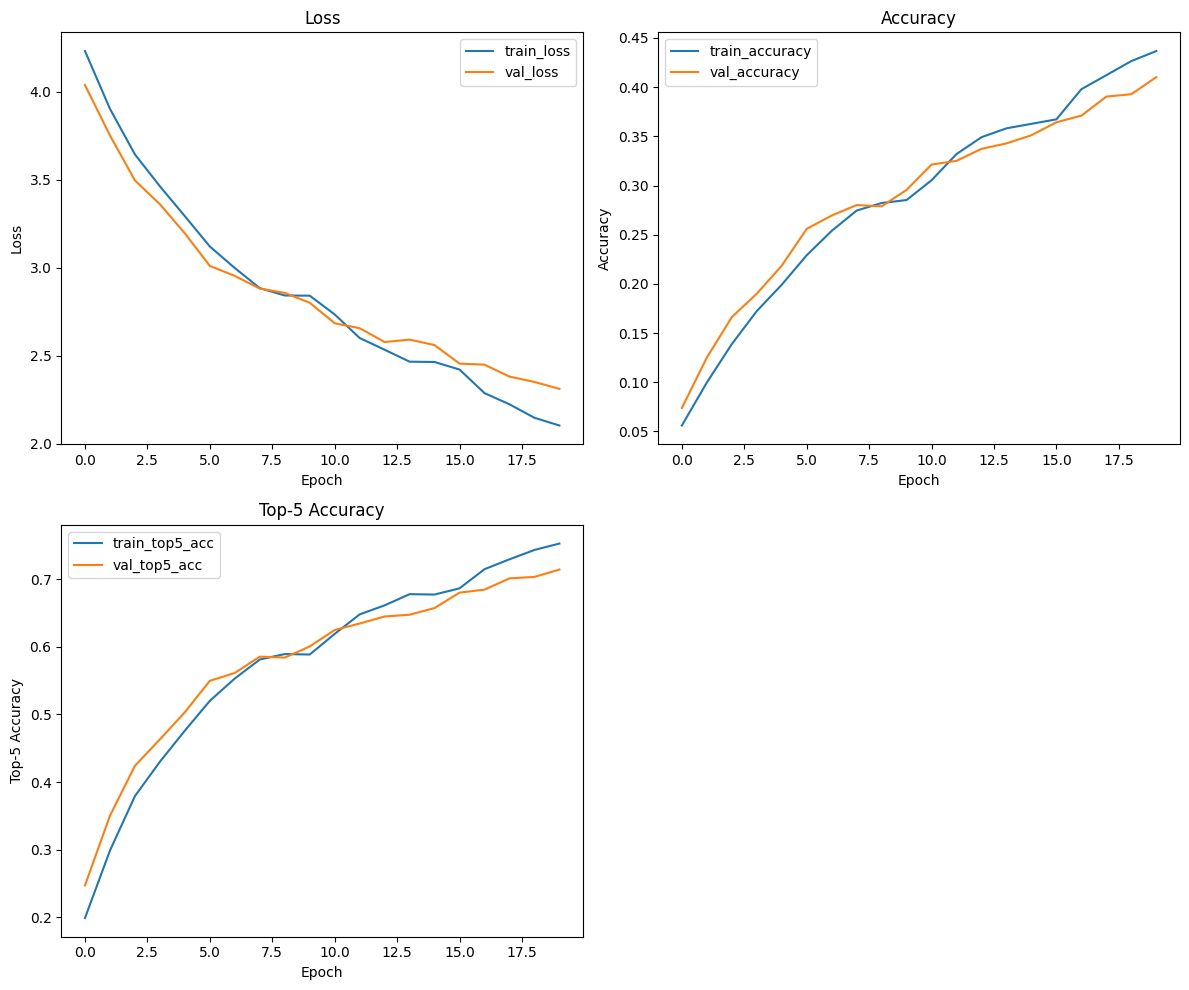

In [42]:
# Cell 9: 绘制训练过程曲线
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss 曲线
axes[0, 0].plot(hist_train_loss, label='train_loss')
axes[0, 0].plot(hist_val_loss, label='val_loss')
axes[0, 0].legend()
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")

# Accuracy 曲线
axes[0, 1].plot(hist_train_acc, label='train_accuracy')
axes[0, 1].plot(hist_val_acc, label='val_accuracy')
axes[0, 1].legend()
axes[0, 1].set_title("Accuracy")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")

# Top-5 Accuracy 曲线
axes[1, 0].plot(hist_train_top5, label='train_top5_acc')
axes[1, 0].plot(hist_val_top5, label='val_top5_acc')
axes[1, 0].legend()
axes[1, 0].set_title("Top-5 Accuracy")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Top-5 Accuracy")

# 空一格以备扩展
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, initializers
import numpy as np

# ------------------ Swin Transformer 核心组件 ------------------ #
class PatchEmbed(layers.Layer):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, patch_size=4, embed_dim=96, norm_layer=None, name=None, **kwargs):
        super(PatchEmbed, self).__init__(name=name, **kwargs)
        self.embed_dim = embed_dim
        self.patch_size = (patch_size, patch_size)
        self.norm = norm_layer(epsilon=1e-6, name="norm") if norm_layer else layers.Activation('linear')
        self.proj = layers.Conv2D(filters=embed_dim, kernel_size=patch_size,
                                  strides=patch_size, padding='SAME',
                                  kernel_initializer=initializers.LecunNormal(),
                                  bias_initializer=initializers.Zeros(),
                                  name="proj")

    def call(self, x, **kwargs):
        # x: [B, H, W, C_in]
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        # C_in = x.shape[3] 可以不显式用C_in，而是直接使用投影后的C
        x = self.proj(x)  # [B, H/patch_size, W/patch_size, C]
        C = tf.shape(x)[3]
        # reshape to [B, H'*W', C]
        x = tf.reshape(x, [B, -1, C])
        x = self.norm(x)
        return x, H, W


def window_partition(x, window_size: int):
    # 使用 tf.shape(x) 获取动态形状
    shape = tf.shape(x)
    B = shape[0]
    H = shape[1]
    W = shape[2]
    C = shape[3]

    # 保证所有的维度计算使用tensor操作，不出现None
    # H // window_size 和 W // window_size 可以使用 tf.math.floordiv
    # 注意：H和W是tensor，需要使用tf.math.floordiv进行整除
    h_div = tf.math.floordiv(H, window_size)
    w_div = tf.math.floordiv(W, window_size)

    x = tf.reshape(x, [B, h_div, window_size, w_div, window_size, C])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, [B * h_div * w_div, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size: int, H: tf.Tensor, W: tf.Tensor):
    num_windows_H = tf.math.floordiv(H, window_size)
    num_windows_W = tf.math.floordiv(W, window_size)
    num_windows = num_windows_H * num_windows_W

    B = tf.math.floordiv(tf.shape(windows)[0], num_windows)
    x = tf.reshape(windows, [B, num_windows_H, num_windows_W, window_size, window_size, -1])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, [B, H, W, -1])
    return x

class PatchMerging(layers.Layer):
    def __init__(self, dim: int, norm_layer=layers.LayerNormalization, name=None, **kwargs):
        super(PatchMerging, self).__init__(name=name, **kwargs)
        self.dim = dim
        self.reduction = layers.Dense(
            2 * dim,
            use_bias=False,
            kernel_initializer=initializers.TruncatedNormal(stddev=0.02),
            name="reduction"
        )
        self.norm = norm_layer(epsilon=1e-6, name="norm")

    def call(self, x, H, W):
        # Retrieve dynamic shape
        shape = tf.shape(x)
        B = shape[0]
        L = shape[1]
        C = shape[2]

        # Assert that L == H * W
        tf.debugging.assert_equal(
            L,
            H * W,
            message="input feature has wrong size"
        )

        # Reshape to [B, H, W, C]
        x = tf.reshape(x, [B, H, W, C])

        # Check if H and W are divisible by 2
        pad_h = tf.math.mod(H, 2)
        pad_w = tf.math.mod(W, 2)
        pad_input = tf.logical_or(tf.not_equal(pad_h, 0), tf.not_equal(pad_w, 0))

        # Define paddings
        paddings = tf.constant([[0, 0],
                                [0, 1],
                                [0, 1],
                                [0, 0]])

        # Conditionally pad the input
        x = tf.cond(
            pad_input,
            lambda: tf.pad(x, paddings),
            lambda: x
        )

        # Perform patch merging
        x0 = x[:, 0::2, 0::2, :]  # [B, H//2, W//2, C]
        x1 = x[:, 1::2, 0::2, :]  # [B, H//2, W//2, C]
        x2 = x[:, 0::2, 1::2, :]  # [B, H//2, W//2, C]
        x3 = x[:, 1::2, 1::2, :]  # [B, H//2, W//2, C]
        x = tf.concat([x0, x1, x2, x3], axis=-1)  # [B, H//2, W//2, 4*C]

        # Calculate new H and W after merging
        new_H = tf.math.floordiv(H + pad_h, 2)
        new_W = tf.math.floordiv(W + pad_w, 2)

        # Reshape to [B, new_H * new_W, 4*C]
        x = tf.reshape(x, [B, new_H * new_W, 4 * C])

        # Apply normalization and reduction
        x = self.norm(x)
        x = self.reduction(x)
        return x


class MLP(layers.Layer):
    k_ini = initializers.TruncatedNormal(stddev=0.02)
    b_ini = initializers.Zeros()
    def __init__(self, in_features, mlp_ratio=4.0, drop=0., name=None):
        super(MLP, self).__init__(name=name)
        self.fc1 = layers.Dense(int(in_features * mlp_ratio), name="fc1",
                                kernel_initializer=self.k_ini, bias_initializer=self.b_ini)
        self.act = layers.Activation("gelu")
        self.fc2 = layers.Dense(in_features, name="fc2",
                                kernel_initializer=self.k_ini, bias_initializer=self.b_ini)
        self.drop = layers.Dropout(drop)

    def call(self, x, training=None):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x, training=training)
        x = self.fc2(x)
        x = self.drop(x, training=training)
        return x

class WindowAttention(layers.Layer):
    k_ini = initializers.GlorotUniform()
    b_ini = initializers.Zeros()
    def __init__(self,
                 dim,
                 window_size,
                 num_heads=8,
                 qkv_bias=False,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.,
                 name=None):
        super(WindowAttention, self).__init__(name=name)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias, name="qkv",
                                kernel_initializer=self.k_ini, bias_initializer=self.b_ini)
        self.attn_drop = layers.Dropout(attn_drop_ratio)
        self.proj = layers.Dense(dim, name="proj",
                                 kernel_initializer=self.k_ini, bias_initializer=self.b_ini)
        self.proj_drop = layers.Dropout(proj_drop_ratio)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(
            shape=[(2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads],
            initializer=initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=tf.float32,
            name="relative_position_bias_table"
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing="ij"))
        coords_flatten = np.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = np.transpose(relative_coords, [1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.relative_position_index = tf.Variable(tf.convert_to_tensor(relative_position_index),
                                                   trainable=False,
                                                   dtype=tf.int64,
                                                   name="relative_position_index")

    def call(self, x, mask=None, training=None):
        # x: [B_, N, C]
        B_ = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]

        # compute qkv
        qkv = self.qkv(x)  # [B_, N, 3*C]
        head_dim = C // self.num_heads

        # reshape qkv to [B_, N, 3, num_heads, head_dim]
        qkv = tf.reshape(qkv, [B_, N, 3, self.num_heads, head_dim])
        # permute to [B_, 3, num_heads, N, head_dim]
        qkv = tf.transpose(qkv, [0, 2, 3, 1, 4])
        # now qkv: [B_, 3, num_heads, N, head_dim]
        # split q,k,v
        q, k, v = tf.unstack(qkv, axis=1)
        # q, k, v: [B_, num_heads, N, head_dim]

        # compute attention
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        # attn: [B_, num_heads, N, N]

        # relative_position_bias_table -> relative_position_bias
        relative_position_bias = tf.gather(self.relative_position_bias_table,
                                          tf.reshape(self.relative_position_index, [-1]))
        relative_position_bias = tf.reshape(relative_position_bias,
                                            [self.window_size[0]*self.window_size[1],
                                            self.window_size[0]*self.window_size[1],
                                            -1])
        # shape: [N, N, num_heads]
        relative_position_bias = tf.transpose(relative_position_bias, [2, 0, 1])
        # shape: [num_heads, N, N]

        # expand dims for broadcasting
        relative_position_bias = tf.expand_dims(relative_position_bias, axis=0)
        # shape: [1, num_heads, N, N]

        attn = attn + relative_position_bias  # shape compatible broadcast

        if mask is not None:
            nW = tf.shape(mask)[0]
            # reshape attn to [B_/nW, nW, num_heads, N, N], add mask, reshape back
            attn = tf.reshape(attn, [B_//nW, nW, self.num_heads, N, N])
            attn = attn + tf.expand_dims(tf.expand_dims(mask, 1), 0)
            attn = tf.reshape(attn, [B_, self.num_heads, N, N])

        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training=training)

        x = tf.matmul(attn, v)  # [B_, num_heads, N, head_dim]
        x = tf.transpose(x, [0, 2, 1, 3])  # [B_, N, num_heads, head_dim]
        x = tf.reshape(x, [B_, N, C])  # [B_, N, C]

        x = self.proj(x)
        x = self.proj_drop(x, training=training)
        return x


class SwinTransformerBlock(layers.Layer):
    def __init__(self,
                 dim,
                 num_heads,
                 window_size=4,
                 shift_size=0,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 name=None,
                 **kwargs):  # Accept additional keyword arguments
        super().__init__(name=name, **kwargs)  # Pass them to the base Layer
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size

        self.norm1 = layers.LayerNormalization(epsilon=1e-6, name="norm1")
        self.attn = WindowAttention(dim,
                                    window_size=(window_size, window_size),
                                    num_heads=num_heads,
                                    qkv_bias=qkv_bias,
                                    attn_drop_ratio=attn_drop,
                                    proj_drop_ratio=drop,
                                    name="attn")
        self.drop_path = layers.Dropout(rate=drop_path, noise_shape=(None, 1, 1)) if drop_path > 0. else layers.Activation("linear")
        self.norm2 = layers.LayerNormalization(epsilon=1e-6, name="norm2")
        self.mlp = MLP(dim, drop=drop, name="mlp")

    def call(self, x, attn_mask, training=None):
        B = tf.shape(x)[0]
        L = tf.shape(x)[1]
        C = tf.shape(x)[2]

        H = tf.cast(self.H, tf.int32)
        W = tf.cast(self.W, tf.int32)

        x = self.norm1(x)
        x = tf.reshape(x, [B, H, W, C])

        pad_r = (self.window_size - (W % self.window_size)) % self.window_size
        pad_b = (self.window_size - (H % self.window_size)) % self.window_size

        paddings = tf.stack([[0,0],[0,pad_b],[0,pad_r],[0,0]])
        x = tf.pad(x, paddings)

        Hp = tf.shape(x)[1]
        Wp = tf.shape(x)[2]

        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=(-self.shift_size, -self.shift_size), axis=(1, 2))
        else:
            shifted_x = x
            attn_mask = None

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, [-1, self.window_size * self.window_size, C])

        attn_windows = self.attn(x_windows, mask=attn_mask, training=training)
        attn_windows = tf.reshape(attn_windows, [-1, self.window_size, self.window_size, C])

        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)

        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=(self.shift_size, self.shift_size), axis=(1,2))
        else:
            x = shifted_x

        # Use tf.slice for dynamic slicing
        x = tf.slice(x, [0, 0, 0, 0], [B, H, W, -1])

        x = tf.reshape(x, [B, H * W, C])
        shortcut = x

        x = shortcut + self.drop_path(x, training=training)
        x = x + self.drop_path(self.mlp(self.norm2(x), training=training), training=training)
        return x
class BasicLayer(layers.Layer):
    def __init__(self,
                 dim,
                 depth,
                 num_heads,
                 window_size,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 downsample=None,
                 name=None,
                 **kwargs):  # Accept additional keyword arguments
        super().__init__(name=name, **kwargs)  # Pass them to the base Layer
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.blocks = [
            SwinTransformerBlock(dim=dim,
                                 num_heads=num_heads,
                                 window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else self.shift_size,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias,
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 name=f"block{i}")
            for i in range(depth)
        ]
        if downsample is not None:
            self.downsample = downsample(dim=dim, name="downsample")
        else:
            self.downsample = None

    def create_mask(self, H, W):
        window_size = self.window_size
        # 计算Hp, Wp逻辑不变...
        Hp = tf.cast(tf.math.ceil(tf.cast(H, tf.float32) / window_size), tf.int32) * window_size
        Wp = tf.cast(tf.math.ceil(tf.cast(W, tf.float32) / window_size), tf.int32) * window_size

        shift_size = self.shift_size
        h1 = Hp - window_size
        h2 = Hp - shift_size
        w1 = Wp - window_size
        w2 = Wp - shift_size

        h_coords = tf.range(Hp)
        w_coords = tf.range(Wp)
        H_grid, W_grid = tf.meshgrid(h_coords, w_coords, indexing='ij')  # [Hp, Wp]

        h_block = tf.where(H_grid < h1, 0, tf.where(H_grid < h2, 1, 2))
        w_block = tf.where(W_grid < w1, 0, tf.where(W_grid < w2, 1, 2))

        img_mask = 3 * h_block + w_block
        img_mask = tf.expand_dims(img_mask, axis=0)
        img_mask = tf.expand_dims(img_mask, axis=-1)

        mask_windows = window_partition(img_mask, window_size)  # [nW, window_size, window_size, 1]
        mask_windows = tf.reshape(mask_windows, [-1, window_size * window_size])
        # 将mask_windows转为float类型，以便后续使用float值填入
        mask_windows = tf.cast(mask_windows, tf.float32)

        attn_mask = tf.expand_dims(mask_windows, 1) - tf.expand_dims(mask_windows, 2)
        # 使用float类型的attn_mask，就不会有类型不匹配的问题
        attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
        attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)

        return attn_mask



    def call(self, x, H, W, training=None):
        attn_mask = self.create_mask(H, W)
        for blk in self.blocks:
            blk.H, blk.W = H, W
            x = blk(x, attn_mask=attn_mask, training=training)

        if self.downsample is not None:
            x = self.downsample(x, H=H, W=W)
            H, W = (H + 1) // 2, (W + 1) // 2
        return x, H, W

class SwinTransformer(Model):
    def __init__(self, patch_size=4, num_classes=100,
                 embed_dim=64, depths=(2, 2), num_heads=(2, 4),
                 window_size=4, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=layers.LayerNormalization, name=None, **kwargs):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.mlp_ratio = mlp_ratio

        self.patch_embed = PatchEmbed(patch_size=patch_size,
                                      embed_dim=embed_dim,
                                      norm_layer=norm_layer)
        self.pos_drop = layers.Dropout(drop_rate)

        dpr = [x for x in np.linspace(0, drop_path_rate, sum(depths))]
        self.stage_layers = []
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias,
                               drop=drop_rate,
                               attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               name=f"layer{i_layer}")
            self.stage_layers.append(layer)

        self.norm = norm_layer(epsilon=1e-6, name="norm")
        self.head = layers.Dense(num_classes,
                                 kernel_initializer=initializers.TruncatedNormal(stddev=0.02),
                                 bias_initializer=initializers.Zeros(),
                                 name="head")

    def call(self, x, training=None):
        x, H, W = self.patch_embed(x)
        x = self.pos_drop(x, training=training)
        for layer in self.stage_layers:
            x, H, W = layer(x, H=H, W=W, training=training)
        x = self.norm(x)
        x = tf.reduce_mean(x, axis=1)
        x = self.head(x)
        return x


# ------------------ CIFAR-100 数据加载与训练示例 ------------------ #

# 加载CIFAR-100数据
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# 数据归一化
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 将标签变为整数张量
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# 构建Dataset
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# 实例化模型
model = SwinTransformer(num_classes=100, patch_size=4, embed_dim=64, depths=(2,2), num_heads=(2,4), window_size=4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# 训练模型
model.fit(train_ds, epochs=10, validation_data=test_ds)

# 验证模型
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node swin_transformer_1/layer0_1/block0_1/Reshape defined at (most recent call last):
<stack traces unavailable>
Input to reshape is a tensor with 262144 values, but the requested shape has 4194304

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-1-40d6346fe299>", line 501, in <cell line: 501>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "<ipython-input-1-40d6346fe299>", line 468, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "<ipython-input-1-40d6346fe299>", line 418, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "<ipython-input-1-40d6346fe299>", line 301, in call

	 [[{{node swin_transformer_1/layer0_1/block0_1/Reshape}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_21407[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_21816]